# Classification

Implement the textbook's system for supervised learning, modifying as needed to run on our literary corpus. Classify the novels as authored by either British/American or female/male writers. Assess the accuracy of the results.

As an optional challenge, see what you can do to speed up the system and/or to get better classification accuracy. In general, this will mean using other methods in the pipeline, though it could involve some additional feature engineering as well.

In [1]:
%matplotlib inline
# Imports and variables

import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import time
import unicodedata
import warnings

from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, train_test_split as tts
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier

# Import our corpus readers
sys.path.append(os.path.join('..', 'libraries'))
import TMN

# File locations
pkl_dir         = os.path.join('..', 'data', 'pickled')
pkl_chk_dir     = os.path.join('..', 'data', 'pickled_chunked')
pkl_chk_nrm_dir = os.path.join('..', 'data', 'pickled_chunked_normalized')
pkl_nrm_dir     = os.path.join('..', 'data', 'pickled_normalized')
img_dir         = os.path.join('..', 'data', 'images')

# Plotting settings
plt.rcParams['figure.figsize'] = [12, 8]

## Original code

In [92]:
# Loader
class CorpusLoader(object):

    def __init__(self, reader, folds=12, shuffle=True, categories=None):
        self.reader = reader
        self.folds  = KFold(n_splits=folds, shuffle=shuffle)
        self.files  = np.asarray(self.reader.fileids(categories=categories))

    def fileids(self, idx=None):
        if idx is None:
            return self.files
        return self.files[idx]

    def documents(self, idx=None):
        for fileid in self.fileids(idx):
            yield list(self.reader.docs(fileids=[fileid]))

    def labels(self, idx=None):
        return [
            self.reader.categories(fileids=[fileid])[0]
            for fileid in self.fileids(idx)
        ]

    def __iter__(self):
        for train_index, test_index in self.folds.split(self.files):
            X_train = self.documents(train_index)
            y_train = self.labels(train_index)

            X_test = self.documents(test_index)
            y_test = self.labels(test_index)

            yield X_train, X_test, y_train, y_test

# Classification system
def identity(words):
    return words


class TextNormalizer(BaseEstimator, TransformerMixin):

    def __init__(self, language='english'):
        self.stopwords  = set(nltk.corpus.stopwords.words(language))
        self.lemmatizer = WordNetLemmatizer()

    def is_punct(self, token):
        return all(
            unicodedata.category(char).startswith('P') for char in token
        )

    def is_stopword(self, token):
        return token.lower() in self.stopwords

    def normalize(self, document):
        return [
            self.lemmatize(token, tag).lower()
            for paragraph in document
            for sentence in paragraph
            for (token, tag) in sentence
            if not self.is_punct(token) and not self.is_stopword(token)
        ]

    def lemmatize(self, token, pos_tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(pos_tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

    def fit(self, X, y=None):
        return self

    def transform(self, documents):
        for document in documents:
            yield self.normalize(document[0])


def create_pipeline(estimator, reduction=False):

    steps = [
        ('normalize', TextNormalizer()),
        ('vectorize', TfidfVectorizer(
            tokenizer=identity, preprocessor=None, lowercase=False
        ))
    ]

    if reduction:
        steps.append((
            'reduction', TruncatedSVD(n_components=10000)
        ))

    # Add the estimator
    steps.append(('classifier', estimator))
    return Pipeline(steps)


def score_models(models, loader):
    for model in models:

        name = model.named_steps['classifier'].__class__.__name__
        if 'reduction' in model.named_steps:
            #name += " (TruncatedSVD)"
            name += ' (' + model.named_steps['reduction'].__class__.__name__ + ')'
        print(name, '::', time.ctime())

        scores = {
            'model': str(model),
            'name': name,
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': [],
            'time': [],
        }

        for X_train, X_test, y_train, y_test in loader:
            start = time.time()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            scores['time'].append(time.time() - start)
            scores['accuracy'].append(accuracy_score(y_test, y_pred))
            scores['precision'].append(precision_score(y_test, y_pred, average='weighted'))
            scores['recall'].append(recall_score(y_test, y_pred, average='weighted'))
            scores['f1'].append(f1_score(y_test, y_pred, average='weighted'))

        yield scores
        
def tabulate_scores(scores):
    import tabulate

    fields = ['model', 'time', 'precision', 'recall', 'accuracy', 'f1']
    table = []

    for score in scores:
        row = [score['name']]
        for field in fields[1:]:
            row.append("{:0.3f}".format(np.mean(score[field])))
        table.append(row)

    table.sort(key=lambda r: r[-1], reverse=True)
    print(tabulate.tabulate(table, headers=fields))

## Original system output

In [16]:
%%time 
labels = ['A', 'B']
corpus = TMN.PickledCorpusReader(pkl_dir)
loader = CorpusLoader(corpus, 4, shuffle=True, categories=labels)

models = []
for form in (LogisticRegression, SGDClassifier):
    models.append(create_pipeline(form(), True))
    models.append(create_pipeline(form(), False))

models.append(create_pipeline(MultinomialNB(), False))
models.append(create_pipeline(GaussianNB(), True))

tabulate_scores(score_models(models, loader))

LogisticRegression (TruncatedSVD) Mon Mar 11 10:46:28 2019


/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mwilkens/anaconda3/envs/w

LogisticRegression Mon Mar 11 10:55:01 2019


/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/

SGDClassifier (TruncatedSVD) Mon Mar 11 10:56:52 2019


/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassi

SGDClassifier Mon Mar 11 11:05:12 2019


/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metric

MultinomialNB Mon Mar 11 11:07:01 2019


/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'pre

GaussianNB (TruncatedSVD) Mon Mar 11 11:08:54 2019


/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


model                                 time    precision    recall    accuracy     f1
---------------------------------  -------  -----------  --------  ----------  -----
GaussianNB (TruncatedSVD)          126.167        0.776     0.775       0.775  0.748
SGDClassifier                       27.241        0.523     0.575       0.575  0.483
LogisticRegression (TruncatedSVD)  128.157        0.478     0.55        0.55   0.476
SGDClassifier (TruncatedSVD)       125.029        0.534     0.55        0.55   0.441
MultinomialNB                       28.277        0.47      0.45        0.45   0.346
LogisticRegression                  27.827        0.486     0.4         0.4    0.281
CPU times: user 38min 13s, sys: 2min 18s, total: 40min 32s
Wall time: 30min 50s


## Profile one model

The original code is pretty slow. We can profile it to see where it's spending most of its time.

In [17]:
%%time
models = []
models.append(create_pipeline(GaussianNB(), True))
%prun tabulate_scores(score_models(models, loader))

GaussianNB (TruncatedSVD) Mon Mar 11 11:19:24 2019


/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


model                         time    precision    recall    accuracy     f1
-------------------------  -------  -----------  --------  ----------  -----
GaussianNB (TruncatedSVD)  159.679        0.737     0.775       0.775  0.742
 CPU times: user 12min 54s, sys: 51.2 s, total: 13min 45s
Wall time: 10min 38s


         381440963 function calls (381440921 primitive calls) in 638.739 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       40  361.317    9.033  363.770    9.094 decomp_lu.py:153(lu)
      272   37.165    0.137   37.165    0.137 {method 'ravel' of 'numpy.ndarray' objects}
      160   20.953    0.131  191.458    1.197 <ipython-input-15-b5ceeca0fc1b>:55(<listcomp>)
 25953288   18.805    0.000   55.893    0.000 <ipython-input-15-b5ceeca0fc1b>:45(is_punct)
 10355044   18.701    0.000   20.951    0.000 wordnet.py:1895(filter_forms)
 52506132   18.251    0.000   30.077    0.000 <ipython-input-15-b5ceeca0fc1b>:47(<genexpr>)
  9620372   17.060    0.000   31.214    0.000 wordnet.py:1889(<listcomp>)
       24   16.263    0.678   16.263    0.678 {built-in method scipy.sparse._sparsetools.csc_matvecs}
 10092488   14.725    0.000   71.539    0.000 wordnet.py:1876(_morphy)
 72082948   13.747    0.000   13.747    0.000 {method 'endsw

## Precompute normalized text and use PCA

The two slow pieces of the original pipeline are text normalization and Truncated SVD feature reduction. We can perform the normalization once and store the output, since it's the same for every instance of the pipeline. And we can use PCA for dimension reduction, which is much faster than SVD. Compare the outputs and runtimes ...

In [3]:
%%time
# Prenormalized input and PCA. Should be much faster ...

class TextNormalizerPre(BaseEstimator, TransformerMixin):        

    def normalize(self, document):
        return [
            token
            for paragraph in document
            for sentence in paragraph
            for token in sentence
        ]

    def fit(self, X, y=None):
        return self

    def transform(self, documents):
        for document in documents:
            yield self.normalize(document[0])

class DenseTransformer(TransformerMixin):
    """
    Need this for input to PCA, which expects a dense matrix.
    """

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

def create_pipeline_pre(estimator, reduction=False):

    steps = [
        ('normalize', TextNormalizerPre()),
        ('vectorize', TfidfVectorizer(
            tokenizer=identity, preprocessor=None, lowercase=False
        )),
        ('make_dense', DenseTransformer())
    ]

    if reduction:
        steps.append((
            'reduction', PCA()
        ))

    # Add the estimator
    steps.append(('classifier', estimator))
    return Pipeline(steps)

labels = ['A', 'B']
corpus_pre = TMN.PickledCorpusReader(pkl_nrm_dir)
loader_pre = CorpusLoader(corpus_pre, 4, shuffle=True, categories=labels)

models = []
models.append(create_pipeline_pre(GaussianNB(), True))
tabulate_scores(score_models(models, loader_pre))

GaussianNB (PCA) Mon Mar 11 13:49:57 2019
model               time    precision    recall    accuracy     f1
----------------  ------  -----------  --------  ----------  -----
GaussianNB (PCA)   3.923        0.745     0.675       0.675  0.668
CPU times: user 16.3 s, sys: 625 ms, total: 17 s
Wall time: 15.7 s


## Chunk the texts

Notice that there are occasional `UndefinedMetricWarning`s in the output above. That's because we have a small corpus; when we split it for cross validation, we sometimes get outputs that don't have any instances of one of the classes among the predicted labels (for example, the model says all the test instances belong to class 'B'). If we divide the corpus into smaller chunks (of, say, 1,000 words each), we'll have a lot more instances to work with and should escape this problem.

For details of the chunking process, see notebook 05.

Note that this code will take a little longer to run than the cell above, since we're using 12-fold cross validation (rather than 4-fold) and comparing three models (rather than 1).

In [6]:
%%time
labels = ['A', 'B']
corpus_pre = TMN.PickledCorpusReader(pkl_chk_nrm_dir)
loader_pre = CorpusLoader(corpus_pre, 12, shuffle=True, categories=labels)

models = []
models.append(create_pipeline_pre(GaussianNB(), True))
models.append(create_pipeline_pre(LogisticRegression(solver='liblinear'), True))
models.append(create_pipeline_pre(SGDClassifier(max_iter=1000, tol=1e-3), True))

tabulate_scores(score_models(models, loader_pre))

GaussianNB (PCA) Mon Mar 11 14:30:08 2019
LogisticRegression (PCA) Mon Mar 11 14:58:58 2019
SGDClassifier (PCA) Mon Mar 11 15:27:20 2019
model                        time    precision    recall    accuracy     f1
------------------------  -------  -----------  --------  ----------  -----
SGDClassifier (PCA)       156.013        0.996     0.996       0.996  0.996
LogisticRegression (PCA)  141.759        0.979     0.979       0.979  0.978
GaussianNB (PCA)          144.159        0.728     0.62        0.62   0.485
CPU times: user 2h 37min 34s, sys: 4min 9s, total: 2h 41min 44s
Wall time: 1h 28min 23s


Check out those f1 scores! Chunking is magic!

OK, not really. What we're seeing is overfitting; we've left shuffling turned on, which means that chunks from each novel are included in both the training and test sets. This defeats the purpose of proper cross-validation. Let's avoid this by turning shuffling off.

In [7]:
%%time
labels = ['A', 'B']
corpus_pre = TMN.PickledCorpusReader(pkl_chk_nrm_dir)
loader_pre = CorpusLoader(corpus_pre, 10, shuffle=False, categories=labels)

models = []
models.append(create_pipeline_pre(GaussianNB(), True))
models.append(create_pipeline_pre(LogisticRegression(solver='liblinear'), True))
models.append(create_pipeline_pre(SGDClassifier(max_iter=1000, tol=1e-3), True))

tabulate_scores(score_models(models, loader_pre))

GaussianNB (PCA) Mon Mar 11 15:58:32 2019


/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/mwilkens

LogisticRegression (PCA) Mon Mar 11 16:22:15 2019


/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/mwilkens/anaconda3/envs

SGDClassifier (PCA) Mon Mar 11 16:45:19 2019


/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/mwilkens/anaconda3/envs

model                        time    precision    recall    accuracy     f1
------------------------  -------  -----------  --------  ----------  -----
SGDClassifier (PCA)       169.413        0.991     0.742       0.742  0.825
LogisticRegression (PCA)  138.372        0.991     0.711       0.711  0.796
GaussianNB (PCA)          142.244        0.801     0.611       0.611  0.603
CPU times: user 2h 10min 23s, sys: 3min 42s, total: 2h 14min 6s
Wall time: 1h 15min 1s


/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/mwilkens/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Evaluate a bunch of classifiers

Back to non-chunked data, but continue using pre-computed normalized texts and PCA dimension-reduction.

AdaBoostClassifier (PCA) :: Mon Mar 11 21:09:27 2019
BernoulliNB (PCA) :: Mon Mar 11 21:11:20 2019
DecisionTreeClassifier (PCA) :: Mon Mar 11 21:13:07 2019
GaussianNB (PCA) :: Mon Mar 11 21:14:56 2019
GaussianProcessClassifier (PCA) :: Mon Mar 11 21:16:35 2019
KNeighborsClassifier (PCA) :: Mon Mar 11 21:17:58 2019
LinearSVC (PCA) :: Mon Mar 11 21:19:26 2019
LogisticRegression (PCA) :: Mon Mar 11 21:20:53 2019
MLPClassifier (PCA) :: Mon Mar 11 21:22:19 2019
NearestCentroid (PCA) :: Mon Mar 11 21:23:43 2019
PassiveAggressiveClassifier (PCA) :: Mon Mar 11 21:25:08 2019
Perceptron (PCA) :: Mon Mar 11 21:26:32 2019
QuadraticDiscriminantAnalysis (PCA) :: Mon Mar 11 21:28:00 2019
RandomForestClassifier (PCA) :: Mon Mar 11 21:29:30 2019
RidgeClassifier (PCA) :: Mon Mar 11 21:30:59 2019
SGDClassifier (PCA) :: Mon Mar 11 21:32:29 2019
SVC (PCA) :: Mon Mar 11 21:33:59 2019


,f1_mean,f1_std
name,,
SGDClassifier (PCA),0.866667,0.221108
Perceptron (PCA),0.866667,0.266667
GaussianNB (PCA),0.833333,0.247207
RidgeClassifier (PCA),0.800000,0.244949
LinearSVC (PCA),0.783333,0.242097
PassiveAggressiveClassifier (PCA),0.766667,0.366667
SVC (PCA),0.733333,0.359011
NearestCentroid (PCA),0.733333,0.290593
MLPClassifier (PCA),0.733333,0.343188


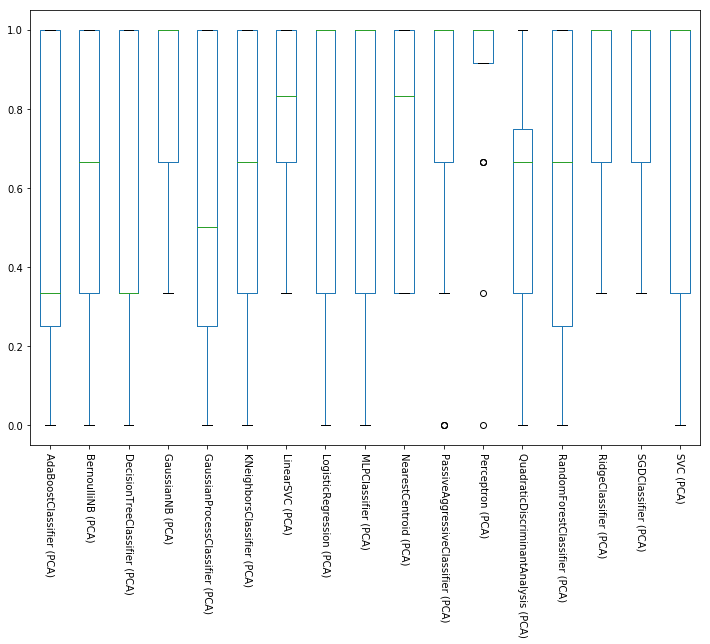

CPU times: user 26min 35s, sys: 47.2 s, total: 27min 22s
Wall time: 26min 5s


In [97]:
%%time
labels = ['A', 'B']
corpus = TMN.PickledCorpusReader(pkl_nrm_dir)
loader = CorpusLoader(corpus, 20, shuffle=True, categories=labels)

def classifier_compare(scores):
    """
    Take output from score_models().
    Tabulate and plot performance.
    """
    df = pd.DataFrame.from_dict(scores)
    pd.DataFrame(
        df['f1'].values.tolist(), 
        index=df.name
    ).T.plot.box(
        figsize=(12,8), 
        rot=-90, 
        sort_columns=True
    )
    df.set_index('name', inplace=True)
    df['f1_mean'] = df.f1.apply(lambda x: np.mean(np.asarray(x)))
    df['f1_std']  = df.f1.apply(lambda x: np.std(np.asarray(x)))
    display(df[['f1_mean', 'f1_std']].sort_values(by='f1_mean', ascending=False))
    plt.show()
    
# redefine create_pipeline with different vectorization settings
def create_pipeline(estimator, reduction=False):

    steps = [
        ('normalize', TextNormalizerPre()),
        ('vectorize', TfidfVectorizer(
            tokenizer=identity, preprocessor=None, lowercase=False,
            min_df=2, max_df=0.5, binary=True
        )),
        ('make_dense', DenseTransformer())
    ]

    if reduction:
        steps.append((
            'reduction', PCA()
        ))

    # Add the estimator
    steps.append(('classifier', estimator))
    return Pipeline(steps)


models = []
models.append(create_pipeline(AdaBoostClassifier(), True))
models.append(create_pipeline(BernoulliNB(), True))
models.append(create_pipeline(DecisionTreeClassifier(max_depth=5), True))
models.append(create_pipeline(GaussianNB(), True))
models.append(create_pipeline(GaussianProcessClassifier(1.0 * RBF(1.0)), True))
models.append(create_pipeline(KNeighborsClassifier(), True))
models.append(create_pipeline(LinearSVC(), True))
models.append(create_pipeline(LogisticRegression(solver='liblinear'), True))
models.append(create_pipeline(MLPClassifier(alpha=1), True))
models.append(create_pipeline(NearestCentroid(), True))
models.append(create_pipeline(PassiveAggressiveClassifier(max_iter=1000, tol=1e-3), True))
models.append(create_pipeline(Perceptron(max_iter=1000, tol=1e-3), True))
models.append(create_pipeline(QuadraticDiscriminantAnalysis(), True))
models.append(create_pipeline(RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), True))
models.append(create_pipeline(RidgeClassifier(tol=1e-2, solver="lsqr"), True))
models.append(create_pipeline(SGDClassifier(max_iter=1000, tol=1e-3), True))
models.append(create_pipeline(SVC(gamma=2, C=1), True))
    
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    classifier_compare(score_models(models, loader))

## Same comparison for F/M classes

AdaBoostClassifier (PCA) :: Mon Mar 11 21:35:31 2019
BernoulliNB (PCA) :: Mon Mar 11 21:37:03 2019
DecisionTreeClassifier (PCA) :: Mon Mar 11 21:38:35 2019
GaussianNB (PCA) :: Mon Mar 11 21:40:07 2019
GaussianProcessClassifier (PCA) :: Mon Mar 11 21:41:39 2019
KNeighborsClassifier (PCA) :: Mon Mar 11 21:43:13 2019
LinearSVC (PCA) :: Mon Mar 11 21:44:45 2019
LogisticRegression (PCA) :: Mon Mar 11 21:46:17 2019
MLPClassifier (PCA) :: Mon Mar 11 21:47:49 2019
NearestCentroid (PCA) :: Mon Mar 11 21:49:22 2019
PassiveAggressiveClassifier (PCA) :: Mon Mar 11 21:50:54 2019
Perceptron (PCA) :: Mon Mar 11 21:52:25 2019
QuadraticDiscriminantAnalysis (PCA) :: Mon Mar 11 21:53:57 2019
RandomForestClassifier (PCA) :: Mon Mar 11 21:55:30 2019
RidgeClassifier (PCA) :: Mon Mar 11 21:57:01 2019
SGDClassifier (PCA) :: Mon Mar 11 21:58:37 2019
SVC (PCA) :: Mon Mar 11 22:00:08 2019


,f1_mean,f1_std
name,,
Perceptron (PCA),0.850000,0.288194
GaussianNB (PCA),0.833333,0.288675
NearestCentroid (PCA),0.800000,0.266667
MLPClassifier (PCA),0.783333,0.303223
RidgeClassifier (PCA),0.783333,0.264050
LinearSVC (PCA),0.783333,0.264050
PassiveAggressiveClassifier (PCA),0.750000,0.347611
SGDClassifier (PCA),0.750000,0.347611
SVC (PCA),0.716667,0.242097


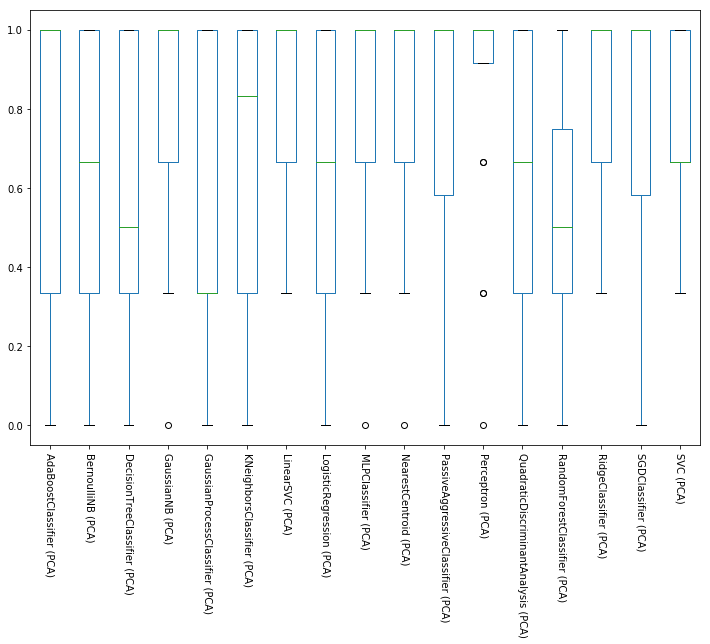

CPU times: user 27min 24s, sys: 42 s, total: 28min 6s
Wall time: 26min 9s


In [98]:
%%time
labels = ['F', 'M']
loader = CorpusLoader(corpus, 20, shuffle=True, categories=labels)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    classifier_compare(score_models(models, loader))

## To try

We've only scratched the surface here. Obvious things to try:

* Standard scaling of features (mean 0, standard deviation 1)
* Other classifiers
* Parameter optimization (note how much better GaussianNB did with different vectorization settings)
* Feature engineering
* More data
* Chunking with test/train splits that respect text boundaries
* Grid search
* ...?